In [ ]:
!pip install haystack.ai trafilatura

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Conversational RAG

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import rich

HF_API_TOKEN = "<YOUR_HF_API_TOKEN>"
OPENAI_API_TOKEN = "<YOUR_OPENAI_API_TOKEN>"


In [ ]:
from typing import List
from haystack.utils import Secret
from haystack import Pipeline
from haystack.components.builders import PromptBuilder
from haystack.components.builders import ChatPromptBuilder
from haystack.components.generators import OpenAIGenerator
from haystack.components.generators.chat.openai import OpenAIChatGenerator
from haystack.dataclasses import ChatMessage

In [ ]:
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.converters.txt import TextFileToDocument
from haystack.components.preprocessors.document_splitter import DocumentSplitter
from haystack.components.embedders import SentenceTransformersDocumentEmbedder, SentenceTransformersTextEmbedder
from haystack.components.writers import DocumentWriter

document_store = InMemoryDocumentStore()


converter = TextFileToDocument()
splitter = DocumentSplitter(split_by='sentence', split_length=1)
embedder = SentenceTransformersDocumentEmbedder("sentence-transformers/all-MiniLM-L6-v2")
writer = DocumentWriter(document_store=document_store)

indexing_pipeline = Pipeline()

indexing_pipeline.add_component("converter", converter)
indexing_pipeline.add_component("splitter", splitter)
indexing_pipeline.add_component("embedder", embedder)
indexing_pipeline.add_component("writer", writer)

indexing_pipeline.connect("converter.documents", "splitter.documents")
indexing_pipeline.connect("splitter.documents", "embedder.documents")
indexing_pipeline.connect("embedder.documents", "writer.documents")

indexing_pipeline.run({"converter": {"sources": ["/content/drive/MyDrive/Colab Notebooks/RAG Code/data/tolkien.txt",
                                                 "/content/drive/MyDrive/Colab Notebooks/RAG Code/data/George_RR_Martin.txt"]}})


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

{'writer': {'documents_written': 92}}

### Create an OpenAIChatGenerator
The [`OpenAIChatGenerator`](https://docs.haystack.deepset.ai/docs/openaichatgenerator?utm_campaign=developer-relations&utm_source=dlai) allows chat completions using OpenAI LLMs.

Messages can come from the following roles:
- system
- assistant
- user

In [ ]:
chat_generator = OpenAIChatGenerator(model="gpt-4o-mini-2024-07-18", api_key=Secret.from_token(OPENAI_API_TOKEN))
replies = chat_generator.run(messages=[ChatMessage.from_user("What was written by George Martin?")])

In [ ]:
rich.print(replies['replies'][0])

ChatMessage(
    _role=<ChatRole.ASSISTANT: 'assistant'>,
    _content=[
        TextContent(
            text='George R.R. Martin is best known for his epic fantasy series "A Song of Ice and Fire," which 
inspired the highly acclaimed television series "Game of Thrones." The main novels in this series include:\n\n1. 
**A Game of Thrones** (1996)\n2. **A Clash of Kings** (1998)\n3. **A Storm of Swords** (2000)\n4. **A Feast for 
Crows** (2005)\n5. **A Dance with Dragons** (2011)\n\nHe has also written a number of related works and novellas, 
including:\n\n- **The Hedge Knight** (1998) - a novella set in the same universe.\n- **The Sworn Sword** (2003) - a
sequel to "The Hedge Knight."\n- **The Mystery Knight** (2010) - another novella in the Dunk and Egg series.\n- 
**Fire & Blood** (2018) - a history of House Targaryen.\n- **The World of Ice & Fire** (2014) - a companion book 
detailing the lore of Westeros.\n\nIn addition to the "A Song of Ice and Fire" series, Martin has written numerous 
short stories, novellas, and other novels in various genres, including science fiction, horror, and fantasy. Some 
notable titles outside of the "A Song of Ice and Fire" series include:\n\n- **Dying of the Light** (1977)\n- 
**Fevre Dream** (1982) - a vampire novel set on the Mississippi River.\n- **The Armageddon Rag** (1983) - a rock 
\'n\' roll horror novel.\n\nMartin has also worked in television, including writing for series like "The Twilight 
Zone."'
        )
    ],
    _name=None,
    _meta={
        'model': 'gpt-4o-mini-2024-07-18',
        'index': 0,
        'finish_reason': 'stop',
        'usage': {
            'completion_tokens': 350,
            'prompt_tokens': 14,
            'total_tokens': 364,
            'completion_tokens_details': CompletionTokensDetails(
                accepted_prediction_tokens=0,
                audio_tokens=0,
                reasoning_tokens=0,
                rejected_prediction_tokens=0
            ),
            'prompt_tokens_details': PromptTokensDetails(audio_tokens=0, cached_tokens=0)
        }
    }
)

In [ ]:
from haystack.components.converters import OutputAdapter

In [ ]:
system_message = ChatMessage.from_system("You are a helpful AI assistant using provided supporting documents and conversation history to assist humans")

user_message_template ="""Given the conversation history and the provided supporting documents, give a brief answer to the question.
Note that supporting documents are not part of the conversation. If question can't be answered exclusive from supporting documents, say so.

    Conversation history:
    {% for memory in memories %}
        {{ memory.text }}
    {% endfor %}

    Supporting documents:
    {% for doc in documents %}
        {{ doc.content }}
    {% endfor %}

    \nQuestion: {{query}}
    \nAnswer:
"""

user_message = ChatMessage.from_user(user_message_template)

In [ ]:
query_rephrase_template = """
        Rewrite the question for search while keeping its meaning and key terms intact.
        If the conversation history is empty, DO NOT change the query.
        Use conversation history only if necessary, and avoid extending the query with your own knowledge.
        If no changes are needed, output the current question as is.

        Conversation history:
        {% for memory in memories %}
            {{ memory.text }}
        {% endfor %}

        User Query: {{query}}
        Rewritten Query:
"""

In [ ]:
chat_generator = OpenAIChatGenerator(model="gpt-4o-mini-2024-07-18", api_key=Secret.from_token(OPENAI_API_TOKEN))


chat_agent = Pipeline()
chat_agent.add_component("query_rephrase_prompt_builder", PromptBuilder(query_rephrase_template))
chat_agent.add_component("query_rephrase_llm", OpenAIGenerator(api_key=Secret.from_token(OPENAI_API_TOKEN)))
chat_agent.add_component("list_to_str_adapter", OutputAdapter(template="{{ replies[0] }}", output_type=str))
chat_agent.add_component("query_embedder", SentenceTransformersTextEmbedder("sentence-transformers/all-MiniLM-L6-v2"))
chat_agent.add_component("retriever", InMemoryEmbeddingRetriever(document_store=document_store, top_k = 3))
chat_agent.add_component("prompt_builder", ChatPromptBuilder(variables=["query", "documents", "memories"], required_variables=["query", "documents", "memories"]))
chat_agent.add_component("generator", chat_generator)




chat_agent.connect("query_rephrase_prompt_builder.prompt", "query_rephrase_llm")
chat_agent.connect("query_rephrase_llm.replies", "list_to_str_adapter")
chat_agent.connect("list_to_str_adapter.output", "query_embedder.text")
chat_agent.connect("query_embedder.embedding", "retriever.query_embedding")

# connections for RAG
chat_agent.connect("retriever.documents", "prompt_builder.documents")
chat_agent.connect("prompt_builder.prompt", "generator.messages")





🚅 Components
  - query_rephrase_prompt_builder: PromptBuilder
  - query_rephrase_llm: OpenAIGenerator
  - list_to_str_adapter: OutputAdapter
  - query_embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: ChatPromptBuilder
  - generator: OpenAIChatGenerator
🛤️ Connections
  - query_rephrase_prompt_builder.prompt -> query_rephrase_llm.prompt (str)
  - query_rephrase_llm.replies -> list_to_str_adapter.replies (List[str])
  - list_to_str_adapter.output -> query_embedder.text (str)
  - query_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> generator.messages (List[ChatMessage])

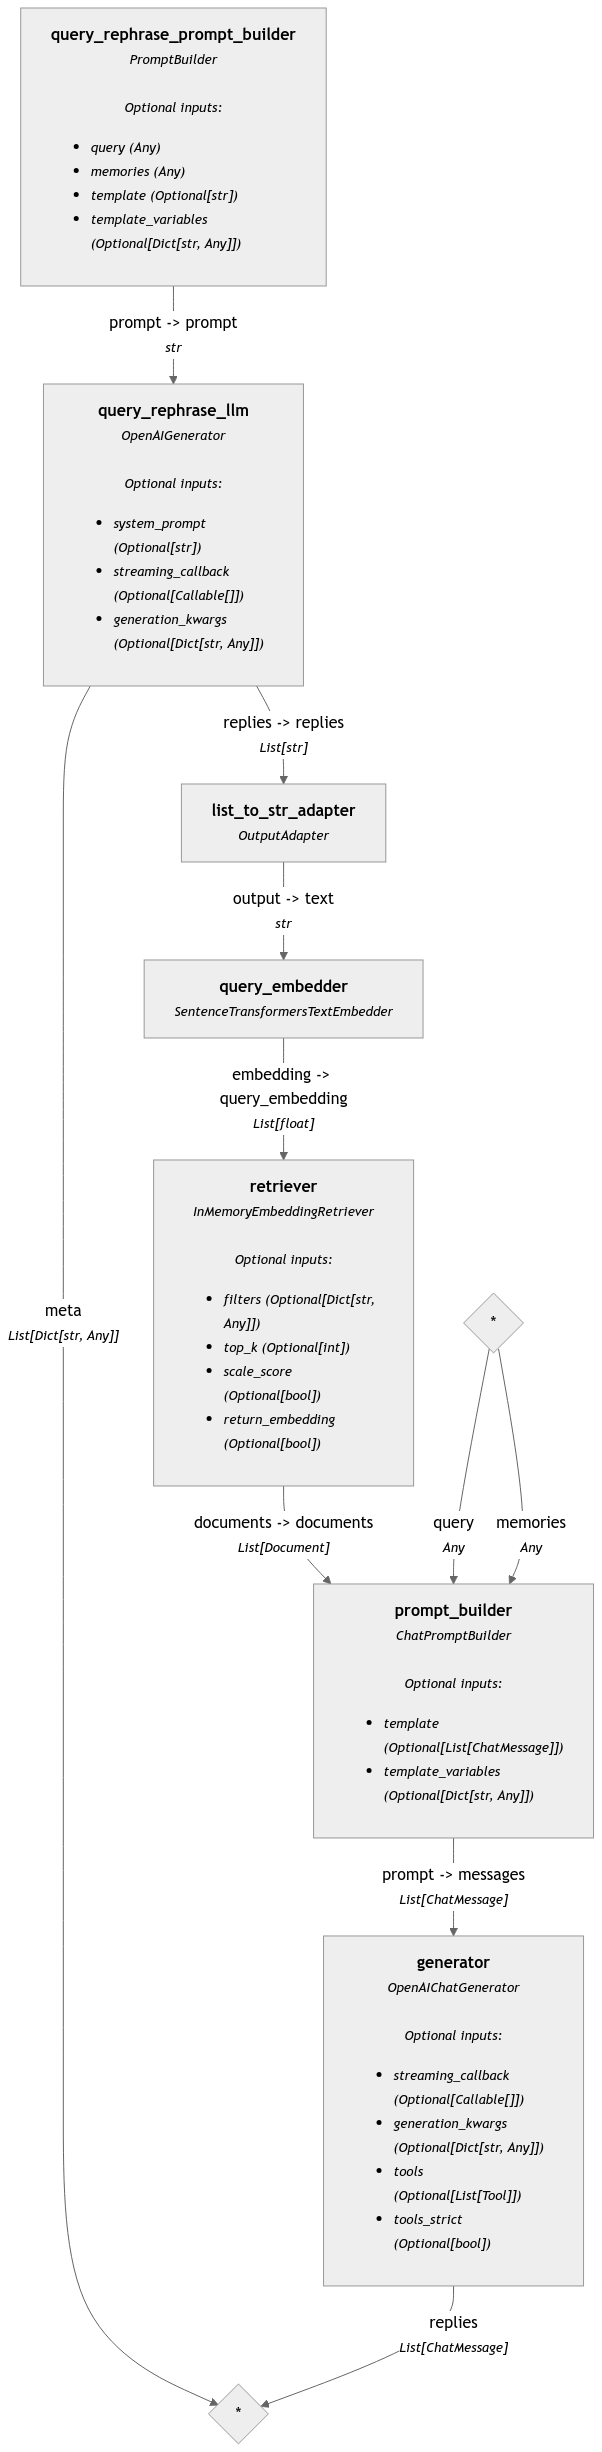

In [ ]:
chat_agent.show()

In [ ]:
messages = []
template = [system_message, user_message]
while True:
    user_input = input("INFO: Type 'exit' or 'quit' to stop\n")
    print(user_input)
    if user_input.lower() == "exit" or user_input.lower() == "quit":
        break
    response = chat_agent.run({"query_rephrase_prompt_builder": {"query": user_input, "memories":messages},
                               "prompt_builder": {"template":template, "query": user_input, "memories":messages},},
                                include_outputs_from={"query_rephrase_llm", "message_collector", "generator"})
    messages.append(ChatMessage.from_user(user_input))
    messages.extend(response['generator']['replies'])
    print(response['query_rephrase_llm']['replies'][0])
    print(response['generator']['replies'][0].text)




INFO: Type 'exit' or 'quit' to stop
Who is Tolkine?'
Who is Tolkine?'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Who is Tolkien?
J.R.R. Tolkien was an influential author born on January 3, 1892, in Bloemfontein, South Africa, known for his significant contributions to high fantasy literature, particularly through works like The Hobbit and the creation of Middle-earth.
INFO: Type 'exit' or 'quit' to stop
What did he write?
What did he write?


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

What works did J.R.R. Tolkien write?
J.R.R. Tolkien wrote several influential works, including the novels The Hobbit and The Lord of the Rings, as well as essays and letters discussing his creative process and philosophical ideas.
INFO: Type 'exit' or 'quit' to stop
exit
exit


In [ ]:
response

{'query_rephrase_llm': {'replies': ['What works did J.R.R. Tolkien write?'],
  'meta': [{'model': 'gpt-4o-mini-2024-07-18',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 11,
     'prompt_tokens': 150,
     'total_tokens': 161,
     'completion_tokens_details': CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0),
     'prompt_tokens_details': PromptTokensDetails(audio_tokens=0, cached_tokens=0)}}]},
 'generator': {'replies': [ChatMessage(_role=<ChatRole.ASSISTANT: 'assistant'>, _content=[TextContent(text='J.R.R. Tolkien wrote several influential works, including the novels The Hobbit and The Lord of the Rings, as well as essays and letters discussing his creative process and philosophical ideas.')], _name=None, _meta={'model': 'gpt-4o-mini-2024-07-18', 'index': 0, 'finish_reason': 'stop', 'usage': {'completion_tokens': 37, 'prompt_tokens': 247, 'total_tokens': 284, 'completion_tokens_de

In [ ]:
messages

[ChatMessage(_role=<ChatRole.USER: 'user'>, _content=[TextContent(text="Who is Tolkine?'")], _name=None, _meta={}),
 ChatMessage(_role=<ChatRole.ASSISTANT: 'assistant'>, _content=[TextContent(text='J.R.R. Tolkien was an influential author born on January 3, 1892, in Bloemfontein, South Africa, known for his significant contributions to high fantasy literature, particularly through works like The Hobbit and the creation of Middle-earth.')], _name=None, _meta={'model': 'gpt-4o-mini-2024-07-18', 'index': 0, 'finish_reason': 'stop', 'usage': {'completion_tokens': 52, 'prompt_tokens': 195, 'total_tokens': 247, 'completion_tokens_details': CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), 'prompt_tokens_details': PromptTokensDetails(audio_tokens=0, cached_tokens=0)}}),
 ChatMessage(_role=<ChatRole.USER: 'user'>, _content=[TextContent(text='What did he write?')], _name=None, _meta={}),
 ChatMessage(_role=<ChatRole.ASSISTAN